Neste exercício, vamos seguir usando o dataset MNIST, assim como nas aulas:

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(float)

O __objetivo__ aqui será construir um algoritmo que faça a __predição se um dígito é par ou ímpar.__

Para isso, faça um tratamento inicial na variável target.

Use a __AUC__ como métrica de performance.

Teste diferentes versões do KNN-Classifier, bem como a regressão logística. 

Use a __metodologia de validação cruzada__, implementando manualmente a AUC, conforme feito nas aulas.

Plote as __curvas ROC__ dos algoritmos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsRegressor


import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Primeiramente separamos os dados em treino e teste
Xtrain, Xtest, ytrain, ytest = X[:55000], X[55000:], y[:55000], y[55000:]

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((55000, 784), (15000, 784), (55000,), (15000,))

In [ ]:

ytrain = np.where(ytrain % 2 ==0 , 1, 0)
ytest = np.where(ytest % 2 ==0 , 1, 0)

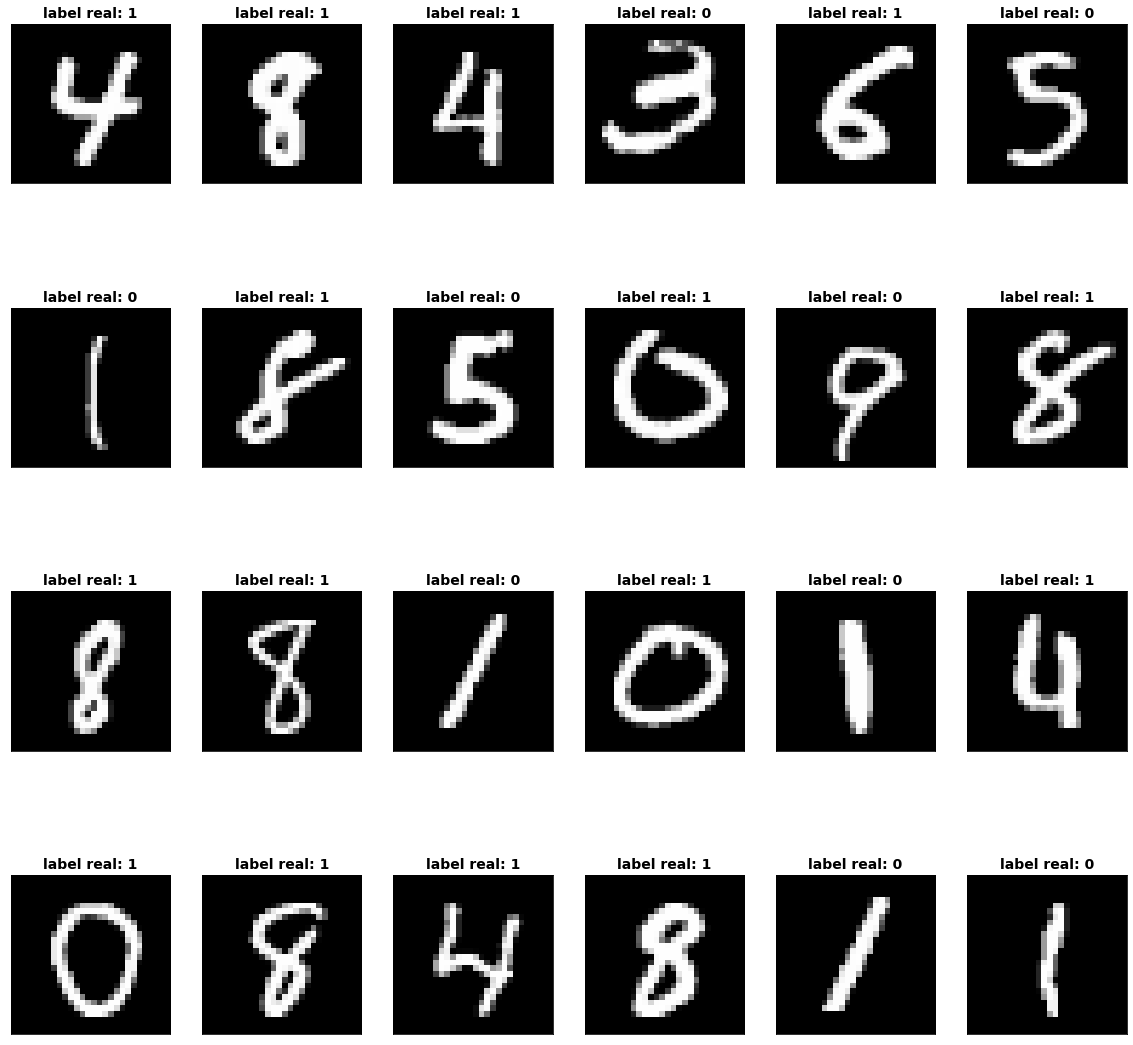

In [ ]:
random_idx = np.random.randint(0,Xtrain.shape[0], size = 24)

plt.figure(figsize=[20,20])
for i in range(len(random_idx)):
    idx_i = random_idx[i]
    xval = Xtrain[idx_i, :].reshape(28,28)
    yval = ytrain[idx_i]
    plt.subplot(4,6,i+1)
    plt.imshow(xval, cmap = plt.cm.Greys_r)
    plt.xticks([])
    plt.yticks([])
    plt.title("label real: "+str(yval), fontsize = 14, fontweight = 'bold')
plt.show()

In [ ]:
print('Percentual de classe positiva: ',(ytrain.sum() / ytrain.size) * 100, '%')
print('Percentual de classe negativa: ',((ytrain.size-ytrain.sum()) / ytrain.size) * 100, '%')

#Aproximadamente metade par e metade ímpar, faz sentido

Percentual de classe positiva:  49.154545454545456 %
Percentual de classe negativa:  50.84545454545455 %


In [ ]:
# começaremos a trabalhar com a regressão logística, inicialmente definindo a função sigmoide e em seguida
#importando os pacotes necessários

In [ ]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

In [ ]:
t0 = time.time()

logreg = LogisticRegression()
logreg.fit(Xtrain, ytrain)

t1 = time.time()
print("tempo (em segundos) para execução: ", np.round(t1-t0,2))

tempo (em segundos) para execução:  7.31


In [ ]:
print(logreg.intercept_)
print(logreg.coef_.size)

[-0.00096029]
784


In [ ]:
logreg.predict(Xtrain)

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
logreg.predict_proba(Xtrain).shape

(55000, 2)

In [ ]:
print(logreg.predict(Xtrain)[:20])
print(ytrain[:20])

#classificador acertou as 20 primeiras, aparenta ter feito um bom trabalho, iremos quantificar

[0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0]
[0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0]


In [ ]:
mat=confusion_matrix(y_true = ytrain, y_pred = logreg.predict(Xtrain))
mat

array([[25110,  2855],
       [ 2703, 24332]], dtype=int64)

In [ ]:
def acuracia(VN,
            VP,
            fp,
            fn):
    return (VN + VP)/ (VP + fp + fn + VP)

In [ ]:
acuracia(VN= 25110, VP= 24332, fp= 2855, fn= 2703)

0.9118439009995942

In [ ]:
#vamos ver o recall que é a possibilidade do classificador acertar quando a classe é positiva, no noso caso, par
mat[1,1] / mat[1, :].sum()

0.9000184945441095

In [ ]:
#agora o valor de precision que é a probabilidade de uma instancia votada positiva pelo classificador realmente ser positiva
mat[1,1] / mat[:, 1].sum()

0.8949865744657373

In [ ]:


f1_score(y_true = ytrain, y_pred = logreg.predict(Xtrain))

0.8974954815388587

In [ ]:

def validacao_cruzada(classificador, 
                      X, 
                      y, 
                      metrica, 
                      num_folds, 
                      print_info = False, 
                      nome_metrica = None):
    
    lista_metrica_treino = []
    lista_metrica_validacao = []
    
    kf = KFold(n_splits = num_folds)
    for train_index, val_index in kf.split(X, y):
        
        Xtrain_folds = X[train_index]
        ytrain_folds = y[train_index]
        Xval_fold = X[val_index]
        yval_fold = y[val_index]
        
        classificador.fit(Xtrain_folds, ytrain_folds)
        
        pred_treino = classificador.predict(Xtrain_folds)
        pred_validacao = classificador.predict(Xval_fold)
        
        lista_metrica_treino.append(metrica(y_pred = pred_treino, y_true = ytrain_folds))
        lista_metrica_validacao.append(metrica(y_pred = pred_validacao, y_true = yval_fold))
        
    if print_info:
        print("Métrica: " + nome_metrica)
        print('média treino:', np.mean(lista_metrica_treino))
        print('média validação:', np.mean(lista_metrica_validacao))
        
    return lista_metrica_treino, lista_metrica_validacao

In [ ]:

t0 = time.time()

for metrica, nome_metrica in zip([precision_score, recall_score, f1_score], ['Precision', 'Recall', 'F1']):
    l1, l2 = validacao_cruzada(classificador = LogisticRegression(),
                 X = Xtrain, 
                 y = ytrain, 
                 metrica = metrica, 
                 num_folds = 5,
                 print_info = True,
                 nome_metrica = nome_metrica)
    print()
    
t1 = time.time()
print("tempo (em segundos) para execução: ", np.round(t1-t0,2))

Métrica: Precision
média treino: 0.8950891058847688
média validação: 0.8887488054435002

Métrica: Recall
média treino: 0.9014762717984748
média validação: 0.8958763151848084

Métrica: F1
média treino: 0.8982708443037122
média validação: 0.8922920192985856

tempo (em segundos) para execução:  95.79


In [ ]:
from sklearn.metrics import roc_curve

In [ ]:
fposT, tposT, thresholdsT = roc_curve(y_true = ytrain, y_score = logreg.predict_proba(Xtrain)[:, 1]) 

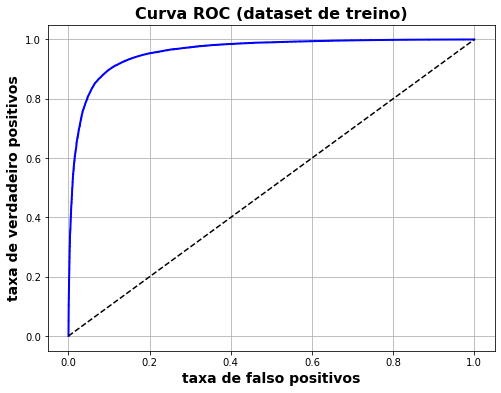

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(fposT, tposT, c = 'blue', lw = 2)
plt.title("Curva ROC (dataset de treino)", fontsize = 16, fontweight = 'bold')
plt.xlabel("taxa de falso positivos", fontsize = 14, fontweight = 'bold')
plt.ylabel("taxa de verdadeiro positivos", fontsize = 14, fontweight = 'bold')
plt.plot([0, 1], [0, 1], 'k--') 
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_true = ytrain, y_score = logreg.predict_proba(Xtrain)[:, 1])

0.9598208479508736

In [ ]:
fpos, tpos, thresholds = roc_curve(y_true = ytest, y_score = logreg.predict_proba(Xtest)[:, 1]) 

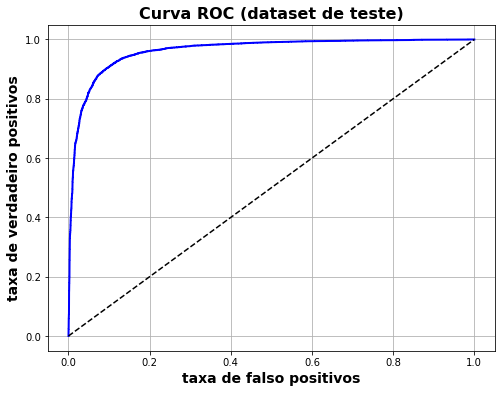

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(fpos, tpos, c = 'blue', lw = 2)
plt.title("Curva ROC (dataset de teste)", fontsize = 16, fontweight = 'bold')
plt.xlabel("taxa de falso positivos", fontsize = 14, fontweight = 'bold')
plt.ylabel("taxa de verdadeiro positivos", fontsize = 14, fontweight = 'bold')
plt.plot([0, 1], [0, 1], 'k--') 
plt.grid()
plt.show()

In [ ]:
roc_auc_score(y_true = ytest, y_score = logreg.predict_proba(Xtest)[:, 1])

0.9623706647471951

In [ ]:
#Os valores da area under curve tanto dos dados de treino, quanto dos dados de teste foram altos e similares, mostrando que
#a regressão logística teve uma boa performance